# 🔬 Robust Nonlinear Control vs PID for a Piezoelectric Actuator
## Based on: Flores & Rakotondrabe, IEEE Control Systems Letters, Vol. 6, 2022

**"Robust Nonlinear Control for a Piezoelectric Actuator in a Robotic Hand Using Only Position Measurements"**

This notebook implements and compares:
1. **Robust Nonlinear Output-Feedback Control** (Observer + Nonlinear Controller)
2. **Classical PID Control**

for a piezoelectrically actuated robotic hand with strong Bouc-Wen hysteresis.

Students can interactively modify parameters to observe:
- Effect of observer gain θ on state estimation
- Effect of control gains (k₁, k₂, κ₁) on tracking performance
- PID tuning and its limitations with strong hysteresis
- Robustness under external disturbances
- Different hysteresis parameter sets

---
**Author:** Dr. Gerardo Flores, RAPTOR Lab, Texas A&M International University

In [71]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'figure.figsize': (14, 8),
    'lines.linewidth': 1.5,
    'grid.alpha': 0.3,
})

# Try to import ipywidgets for interactive mode (Colab)
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    print("ipywidgets not available — running in static mode.")

print("✅ All imports successful!")
print("="*65)
print("  Robust Nonlinear Control for Piezoelectric Actuators")
print("  Flores & Rakotondrabe, IEEE CSL, Vol. 6, 2022")
print("="*65)

✅ All imports successful!
  Robust Nonlinear Control for Piezoelectric Actuators
  Flores & Rakotondrabe, IEEE CSL, Vol. 6, 2022


## System Model

The piezoelectric actuator is modeled as a **Hammerstein structure**:

**Hysteresis (Bouc-Wen):**
$$\dot{h} = A_{bw}\dot{u} - B_{bw}|\dot{u}|h - G_{bw}\dot{u}|h| + \delta_h(t)$$

**Linear Dynamics:**
$$\dot{x} = Ax + B(d_p u - h) + \delta_x(t)$$

**Output:**
$$y = Cx = x$$

where $h$ is the hysteresis state, $x$ is the position, $u$ is the voltage input,
and $\delta_h$, $\delta_x$ are external disturbances.

In [72]:

# ---- Parameter Sets from Table I of the paper ----
PARAM_SETS = {
    "Set 1 (Baseline)":       {"Abw": 0.8,  "Bbw": 0.2,  "Gbw": 0.03, "dp": 0.3},
    "Set 2 (Wider loop)":     {"Abw": 0.9,  "Bbw": 0.1,  "Gbw": 0.01, "dp": 0.3},
    "Set 3 (Asymmetric)":     {"Abw": 0.5,  "Bbw": 0.15, "Gbw": 0.1,  "dp": 0.3},
    "Set 4 (Strong hyst.)":   {"Abw": 1.2,  "Bbw": 0.05, "Gbw": 0.02, "dp": 0.3},
}

# Linear dynamics parameters
TAU = 0.01       # Time constant (s)
A_LIN = -1.0/TAU  # = -1000
B_LIN = 1.0/TAU   # = 1000

# Reference signal
AMP = 80.0           # Amplitude (μm)
FREQ = 1.0           # Frequency (Hz)
OMEGA = 2*np.pi*FREQ

print("Parameter sets loaded:")
for name, p in PARAM_SETS.items():
    print(f"  {name}: Abw={p['Abw']}, Bbw={p['Bbw']}, Gbw={p['Gbw']}, dp={p['dp']}")

Parameter sets loaded:
  Set 1 (Baseline): Abw=0.8, Bbw=0.2, Gbw=0.03, dp=0.3
  Set 2 (Wider loop): Abw=0.9, Bbw=0.1, Gbw=0.01, dp=0.3
  Set 3 (Asymmetric): Abw=0.5, Bbw=0.15, Gbw=0.1, dp=0.3
  Set 4 (Strong hyst.): Abw=1.2, Bbw=0.05, Gbw=0.02, dp=0.3


In [73]:

def reference_signal(t, amp=AMP, omega=OMEGA):
    """Desired trajectory and its derivative."""
    xd = amp * np.sin(omega * t)
    xd_dot = amp * omega * np.cos(omega * t)
    xd_ddot = -amp * omega**2 * np.sin(omega * t)
    return xd, xd_dot, xd_ddot


def disturbances(t, enable=False, dx_amp=30.0, dh_amp=25.0):
    """External disturbances δ_x and δ_h."""
    if not enable:
        return 0.0, 0.0
    delta_x = dx_amp
    delta_h = dh_amp * np.sin(t)
    return delta_x, delta_h


def bouc_wen_dhdt(h, u_dot, Abw, Bbw, Gbw):
    """Bouc-Wen hysteresis dynamics: ḣ (without disturbance)."""
    return Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h)

## Robust Nonlinear Output-Feedback Control

### Observer (Proposition 1):
$$\dot{\hat{z}} = \Gamma\hat{z} + g(\hat{z}, \dot{u}) - S^{-1}\bar{C}^\top(\hat{z}_1 - z_1)$$

where $S$ solves $\theta S + \Gamma^\top S + S\Gamma - \bar{C}^\top\bar{C} = 0$

### Virtual Control — Desired Hysteresis (Eq. 8):
$$h_d = \frac{1}{B}\left[(A+\kappa_1)\tilde{x} + Ax_d - \dot{x}_d + Bd_pu\right]$$

### Nonlinear Control — Super-Twisting (Eq. 21):
$$\dot{u} = \frac{1}{A_{bw}}\left[k_1 \mathrm{sgn}(\hat{h}-h_d)\sqrt{|\hat{h}-h_d|} + k_2 (\hat{h}-h_d)\right]$$

The voltage $u$ is obtained by integrating $\dot{u}$.
The super-twisting drives the error $\hat{h} - h_d \to 0$,
achieving hysteresis compensation through the Bouc-Wen inverse.

In [97]:

def simulate_robust_control(params, ctrl_gains, obs_gain, t_span, dt,
                            disturbance=False, dx_amp=30.0, dh_amp=25.0,
                            x0=3.0, h0=-2.0, u0=0.0):
    """
    Simulate the output-feedback system with observer-based hysteresis compensation.

    States: [x, h, u, x_hat, h_hat]
    x, h       = true plant states
    u          = control voltage (obtained by integrating u̇)
    x_hat, h_hat = observer estimates

    Control law based on Eq. (8) and (21) of the paper:

    1. Desired hysteresis state (Eq. 8):
        h_d = (1/B) · [(A + κ₁)x̃ + Ax_d - ẋ_d + B·d_p·u]

    2. Super-twisting controller (Eq. 21):
        u̇ = (1/A_bw) · [k₁ sgn(ê)√|ê| + k₂ ê]
       where ê = ĥ - h_d

    The voltage u is a state that evolves by integrating u̇.
    The controller drives ĥ toward h_d via the Bouc-Wen inverse,
    achieving hysteresis compensation with only position measurements.

    Note: The sign convention in the super-twisting is adapted for our
    plant model where the dp·u term in h_d creates a direct algebraic
    coupling between u and the error surface ê = ĥ - h_d.
    """
    Abw = params["Abw"]
    Bbw = params["Bbw"]
    Gbw = params["Gbw"]
    dp  = params["dp"]

    k1     = ctrl_gains["k1"]
    k2     = ctrl_gains["k2"]
    kappa1 = ctrl_gains["kappa1"]
    theta  = obs_gain

    # Observer gain matrix via Riccati-like solution
    B = B_LIN
    S11 = 1.0/theta
    S12 = B/(theta**2)
    S22 = 2.0*B**2/(theta**3)
    det_S = S11*S22 - S12**2
    L1 = S22 / det_S
    L2 = -S12 / det_S

    u_max = 400.0
    h_sat = 300.0
    slew_max = 5000.0     # max |du/dt| in V/s

    def sat(val, bound):
        return np.clip(val, -bound, bound)

    def dynamics(t, state):
        x, h, u, x_hat, h_hat = state
        xd, xd_dot, xd_ddot = reference_signal(t)
        delta_x, delta_h = disturbances(t, disturbance, dx_amp, dh_amp)

        # Saturate observer estimates (peaking prevention)
        h_hat_s = sat(h_hat, h_sat)
        u_clipped = sat(u, u_max)

        # ---- Eq. (8): Desired hysteresis state h_d ----
        x_tilde = x - xd
        h_d = (1.0/B_LIN) * ((A_LIN + kappa1)*x_tilde
                              + A_LIN*xd - xd_dot
                              + B_LIN*dp*u_clipped)

        # ---- Error surface: ê = ĥ - h_d ----
        e = h_hat_s - h_d
        abs_e = max(abs(e), 1e-14)

        # ---- Eq. (21): Super-twisting controller ----
        # u̇ = (1/Abw) · [k₁ sgn(ê)√|ê| + k₂ ê]
        #
        #u_dot = (1.0/Abw) * (k1 * np.sign(e) * np.sqrt(abs_e) + k2 * e)
        #
        alpha = 10.0  # ajusta suavidad (10–200 típico)
        smooth_sign = (2/np.pi) * np.arctan(alpha * e)
        smooth_abs_sqrt = np.sqrt(e**2 + 1e-6)
        u_dot = (1.0/Abw) * ( k1 * smooth_sign * smooth_abs_sqrt + k2 * e )
        #u_dot = (1.0/Abw) * ( k1 * smooth_sign * np.sqrt(abs_e)  + k2 * e )

        u_dot = sat(u_dot, slew_max)

        # Anti-windup
        if (u >= u_max and u_dot > 0) or (u <= -u_max and u_dot < 0):
            u_dot = 0.0

        # ---- True plant dynamics ----
        dh = bouc_wen_dhdt(h, u_dot, Abw, Bbw, Gbw) + delta_h
        dx = A_LIN * x + B_LIN * (dp * u_clipped - h) + delta_x

        # ---- Observer dynamics ----
        innovation = x_hat - x  # y = x is measured
        dx_hat = (A_LIN * x_hat + B_LIN * dp * u_clipped
                  - B_LIN * h_hat_s - L1 * innovation)
        dh_hat = (bouc_wen_dhdt(h_hat_s, u_dot, Abw, Bbw, Gbw)
                  - L2 * innovation)

        return [dx, dh, u_dot, dx_hat, dh_hat]

    y0 = [x0, h0, u0, 0.0, 0.0]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, y0, method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)

    return sol

## Classical PID Control

For comparison, a standard PID controller is applied directly:
$$u(t) = K_p e(t) + K_i \int_0^t e(\tau)d\tau + K_d \dot{e}(t)$$

where $e(t) = y_d(t) - y(t)$ is the tracking error.

**Note:** The PID does NOT use any hysteresis model information.

In [98]:

def simulate_pid(params, pid_gains, t_span, dt,
                 disturbance=False, dx_amp=30.0, dh_amp=25.0,
                 x0=3.0, h0=-2.0):
    """
    Simulate PID control of the piezoelectric actuator.
    States: [x, h, u, integral_error]
    u evolves via first-order filter: τ_u * du/dt = u_pid - u
    """
    Abw = params["Abw"]
    Bbw = params["Bbw"]
    Gbw = params["Gbw"]
    dp  = params["dp"]

    Kp = pid_gains["Kp"]
    Ki = pid_gains["Ki"]
    Kd = pid_gains["Kd"]

    u_max = 200.0     # voltage saturation
    tau_u = 0.001     # filter time constant for smooth u_dot

    def dynamics(t, state):
        x, h, u, int_err = state
        xd, xd_dot, _ = reference_signal(t)
        delta_x, delta_h = disturbances(t, disturbance, dx_amp, dh_amp)

        # PID error
        err = xd - x

        # PID control law (desired voltage)
        u_pid = Kp * err + Ki * int_err + Kd * xd_dot
        u_pid = np.clip(u_pid, -u_max, u_max)

        # Smooth u through first-order filter
        u_dot = (u_pid - u) / tau_u

        # Plant dynamics
        dh = Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h) + delta_h
        dx = A_LIN * x + B_LIN * (dp * u - h) + delta_x

        # Integrator
        d_int = err

        return [dx, dh, u_dot, d_int]

    y0 = [x0, h0, 0.0, 0.0]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, y0, method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)

    return sol

In [99]:

def simulate_open_loop(params, t_span, dt, u_amp=150.0,
                       x0=0.0, h0=0.0):
    """
    Open-loop: apply sinusoidal voltage, observe hysteresis in (u,y) map.
    States: [x, h]
    """
    Abw = params["Abw"]
    Bbw = params["Bbw"]
    Gbw = params["Gbw"]
    dp  = params["dp"]

    def dynamics(t, state):
        x, h = state
        u = u_amp * np.sin(OMEGA * t)
        u_dot = u_amp * OMEGA * np.cos(OMEGA * t)

        dh = Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h)
        dx = A_LIN * x + B_LIN * (dp * u - h)
        return [dx, dh]

    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, y0=[x0, h0], method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    return sol

In [100]:

COLORS = {
    'robust': '#1b5e8c',
    'pid': '#c0392b',
    'ref': '#2c3e50',
    'observer': '#16a085',
    'openloop': '#8e44ad',
    'dist': '#e67e22',
}

def plot_comparison(sol_robust, sol_pid, sol_ol, params_name,
                    ctrl_gains, pid_gains, obs_gain,
                    disturbance=False, save_name=None):
    """Generate comprehensive comparison plots."""

    fig = plt.figure(figsize=(16, 14))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

    # ---- (a) Open-loop hysteresis: (u, y) map ----
    ax1 = fig.add_subplot(gs[0, 0])
    t_ol = sol_ol.t
    x_ol = sol_ol.y[0]
    u_ol = 150.0 * np.sin(OMEGA * t_ol)
    # Use last 2 cycles
    mask = t_ol > t_ol[-1] - 2.0/FREQ
    ax1.plot(u_ol[mask], x_ol[mask], color=COLORS['openloop'], lw=1.5)
    ax1.set_xlabel('Voltage $u$ (V)')
    ax1.set_ylabel('Position $y$ (μm)')
    ax1.set_title('(a) Open-Loop: Hysteresis Map $(u,y)$')
    ax1.grid(True, alpha=0.3)

    # ---- (b) Closed-loop robust: (yd, y) map ----
    ax2 = fig.add_subplot(gs[0, 1])
    t_r = sol_robust.t
    x_r = sol_robust.y[0]
    xd_r = AMP * np.sin(OMEGA * t_r)
    mask = t_r > t_r[-1] - 2.0/FREQ
    ax2.plot(xd_r[mask], x_r[mask], color=COLORS['robust'], lw=1.5)
    ax2.plot([-AMP, AMP], [-AMP, AMP], 'k--', lw=0.8, alpha=0.4, label='Ideal')
    ax2.set_xlabel('$y_d$ (μm)')
    ax2.set_ylabel('$y$ (μm)')
    ax2.set_title('(b) Robust Control: Map $(y_d, y)$')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)

    # ---- (c) Closed-loop PID: (yd, y) map ----
    ax3 = fig.add_subplot(gs[0, 2])
    t_p = sol_pid.t
    x_p = sol_pid.y[0]
    xd_p = AMP * np.sin(OMEGA * t_p)
    mask = t_p > t_p[-1] - 2.0/FREQ
    ax3.plot(xd_p[mask], x_p[mask], color=COLORS['pid'], lw=1.5)
    ax3.plot([-AMP, AMP], [-AMP, AMP], 'k--', lw=0.8, alpha=0.4, label='Ideal')
    ax3.set_xlabel('$y_d$ (μm)')
    ax3.set_ylabel('$y$ (μm)')
    ax3.set_title('(c) PID Control: Map $(y_d, y)$')
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)

    # ---- (d) Position tracking comparison ----
    ax4 = fig.add_subplot(gs[1, :2])
    xd_all = AMP * np.sin(OMEGA * t_r)
    ax4.plot(t_r, xd_all, 'k--', lw=1, alpha=0.5, label='$y_d$')
    ax4.plot(t_r, x_r, color=COLORS['robust'], lw=1.5, label='Robust')
    if len(t_p) == len(t_r):
        ax4.plot(t_p, x_p, color=COLORS['pid'], lw=1.2, ls='-.', label='PID')
    else:
        ax4.plot(t_p, x_p, color=COLORS['pid'], lw=1.2, ls='-.', label='PID')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Position $y$ (μm)')
    ax4.set_title('(d) Position Tracking: Robust vs PID')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, t_r[-1]])

    # ---- (e) Tracking error ----
    ax5 = fig.add_subplot(gs[1, 2])
    err_r = AMP * np.sin(OMEGA * t_r) - x_r
    err_p = AMP * np.sin(OMEGA * t_p) - x_p
    # Use last 3 cycles for steady-state error
    mask_r = t_r > t_r[-1] - 3.0/FREQ
    mask_p = t_p > t_p[-1] - 3.0/FREQ
    ax5.plot(t_r[mask_r], err_r[mask_r], color=COLORS['robust'], lw=1.5, label='Robust')
    ax5.plot(t_p[mask_p], err_p[mask_p], color=COLORS['pid'], lw=1.2, ls='-.', label='PID')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Error $y_d - y$ (μm)')
    ax5.set_title('(e) Steady-State Tracking Error')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # ---- (f) Observer convergence ----
    ax6 = fig.add_subplot(gs[2, 0])
    x_hat = sol_robust.y[3]
    h_hat = sol_robust.y[4]
    h_true = sol_robust.y[1]
    eps_x = x_hat - x_r
    eps_h = h_hat - h_true
    ax6.plot(t_r, eps_x, color=COLORS['observer'], lw=1.2, label='$\\hat{x}-x$')
    ax6.plot(t_r, eps_h, color=COLORS['dist'], lw=1.2, label='$\\hat{h}-h$')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Observer Error')
    ax6.set_title(f'(f) Observer Convergence ($\\theta={obs_gain}$)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim([0, min(0.5, t_r[-1])])

    # ---- (g) Control voltage ----
    ax7 = fig.add_subplot(gs[2, 1])
    u_r = sol_robust.y[2]
    u_p = sol_pid.y[2]
    ax7.plot(t_r, u_r, color=COLORS['robust'], lw=1.2, label='Robust $u$')
    ax7.plot(t_p, u_p, color=COLORS['pid'], lw=1, ls='-.', label='PID $u$')
    ax7.set_xlabel('Time (s)')
    ax7.set_ylabel('Voltage $u$ (V)')
    ax7.set_title('(g) Control Input')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim([0, t_r[-1]])

    # ---- (h) Performance metrics ----
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')

    # Compute metrics (steady state, last 3 cycles)
    rmse_r = np.sqrt(np.mean(err_r[mask_r]**2))
    rmse_p = np.sqrt(np.mean(err_p[mask_p]**2))
    max_r = np.max(np.abs(err_r[mask_r]))
    max_p = np.max(np.abs(err_p[mask_p]))

    dist_str = "ON" if disturbance else "OFF"
    info_text = (
        f"━━━━ Performance Metrics ━━━━\n\n"
        f"Parameters: {params_name}\n"
        f"Disturbances: {dist_str}\n\n"
        f"{'Metric':<18}{'Robust':>10}{'PID':>10}\n"
        f"{'─'*38}\n"
        f"{'RMSE (μm)':<18}{rmse_r:>10.3f}{rmse_p:>10.3f}\n"
        f"{'Max |e| (μm)':<18}{max_r:>10.3f}{max_p:>10.3f}\n\n"
        f"━━━ Control Gains ━━━\n"
        f"k₁={ctrl_gains['k1']}, k₂={ctrl_gains['k2']}\n"
        f"κ₁={ctrl_gains['kappa1']}, θ={obs_gain}\n\n"
        f"━━━ PID Gains ━━━\n"
        f"Kp={pid_gains['Kp']}, Ki={pid_gains['Ki']}\n"
        f"Kd={pid_gains['Kd']}"
    )
    ax8.text(0.05, 0.95, info_text, transform=ax8.transAxes,
             fontsize=10, fontfamily='monospace', verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', alpha=0.8))

    fig.suptitle(f'Piezoelectric Actuator Control Comparison — {params_name}',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_name:
        fig.savefig(save_name, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_name}")

    plt.show()


def plot_observer_detail(sol_robust, obs_gain):
    """Detailed observer analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    t = sol_robust.t
    x = sol_robust.y[0]
    h = sol_robust.y[1]
    x_hat = sol_robust.y[3]
    h_hat = sol_robust.y[4]

    # (a) x vs x_hat
    axes[0, 0].plot(t, x, 'k', lw=1.5, label='$x$ (true)')
    axes[0, 0].plot(t, x_hat, '--', color=COLORS['observer'], lw=1.2, label='$\\hat{x}$ (observer)')
    axes[0, 0].set_title('(a) Position State: True vs Estimated')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 1.0])

    # (b) h vs h_hat
    axes[0, 1].plot(t, h, 'k', lw=1.5, label='$h$ (true)')
    axes[0, 1].plot(t, h_hat, '--', color=COLORS['observer'], lw=1.2, label='$\\hat{h}$ (observer)')
    axes[0, 1].set_title('(b) Hysteresis State: True vs Estimated')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, 1.0])

    # (c) Observer errors
    axes[1, 0].plot(t, x_hat - x, color=COLORS['observer'], lw=1.2, label='$\\epsilon_x$')
    axes[1, 0].plot(t, h_hat - h, color=COLORS['dist'], lw=1.2, label='$\\epsilon_h$')
    axes[1, 0].set_title(f'(c) Observer Errors ($\\theta={obs_gain}$)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_xlim([0, 0.5])

    # (d) Observer error norm
    eps_norm = np.sqrt((x_hat - x)**2 + (h_hat - h)**2)
    axes[1, 1].semilogy(t, eps_norm + 1e-16, color=COLORS['robust'], lw=1.5)
    axes[1, 1].set_title('(d) Observer Error Norm $\\|\\epsilon\\|$ (log scale)')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim([0, 1.0])

    fig.suptitle(f'Observer Convergence Analysis (θ = {obs_gain})', fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_hysteresis_sets(params_dict, ctrl_gains, obs_gain, t_span, dt):
    """Reproduce Fig. 8: closed-loop for all parameter sets."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes_flat = axes.flatten()

    for idx, (name, params) in enumerate(params_dict.items()):
        ax = axes_flat[idx]
        print(f"  Simulating {name}...")
        sol = simulate_robust_control(params, ctrl_gains, obs_gain, t_span, dt)
        t = sol.t
        x = sol.y[0]
        xd = AMP * np.sin(OMEGA * t)
        ax.plot(t, x, color=COLORS['robust'], lw=1.2, label='$y$')
        ax.plot(t, xd, 'k--', lw=0.8, alpha=0.4, label='$y_d$')
        ax.set_title(name)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (μm)')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle('Robust Control Performance Across Parameter Sets (Fig. 8 from paper)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 🚀 Run Simulation with Default Parameters

Using the paper's formulation with tuned gains:
- **Control:** k₁ = 1000, k₂ = 300, κ₁ = 200
- **Observer:** θ = 100
- **PID:** Kp = 5, Ki = 50, Kd = 0.001

Running simulations (Set 1, no disturbances)...
  [1/3] Open-loop...
  [2/3] Robust nonlinear control...
  [3/3] PID control...
Done!



/var/folders/vr/87wp5c1x6274y4s_9gfd2r8xg10zkr/T/ipykernel_30037/1461810231.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


  Saved: fig_comparison_set1.png


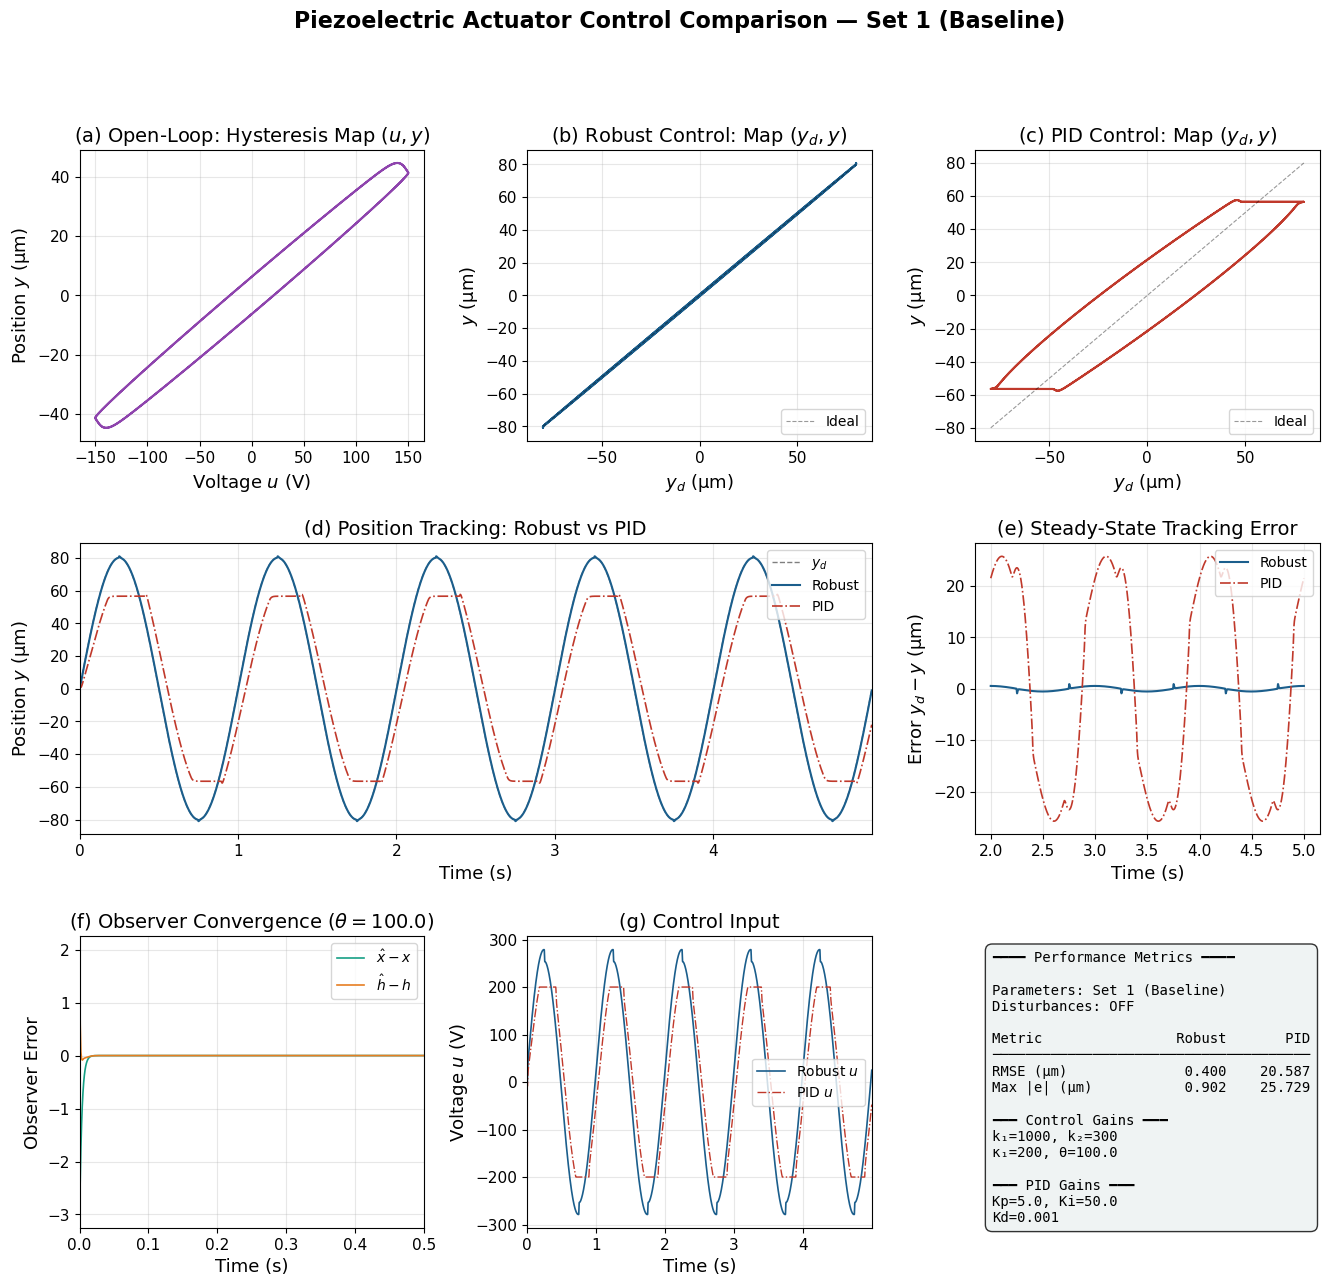

In [108]:

# Default gains
ctrl_gains_default = {"k1": 1000, "k2": 300, "kappa1": 200} #k₁ = 800, k₂ = 500, κ₁ = 500
pid_gains_default = {"Kp": 5.0, "Ki": 50.0, "Kd": 0.001}
obs_gain_default = 100.0

# Simulation parameters
T_FINAL = 5.0
DT = 0.001

params = PARAM_SETS["Set 1 (Baseline)"]

print("Running simulations (Set 1, no disturbances)...")
print("  [1/3] Open-loop...")
sol_ol = simulate_open_loop(params, [0, T_FINAL], DT, u_amp=150.0)
print("  [2/3] Robust nonlinear control...")
sol_robust = simulate_robust_control(params, ctrl_gains_default, obs_gain_default,
                                      [0, T_FINAL], DT)
print("  [3/3] PID control...")
sol_pid = simulate_pid(params, pid_gains_default, [0, T_FINAL], DT)
print("Done!\n")

plot_comparison(sol_robust, sol_pid, sol_ol,
                "Set 1 (Baseline)", ctrl_gains_default,
                pid_gains_default, obs_gain_default,
                save_name="fig_comparison_set1.png")


📐 Observer Convergence Analysis:


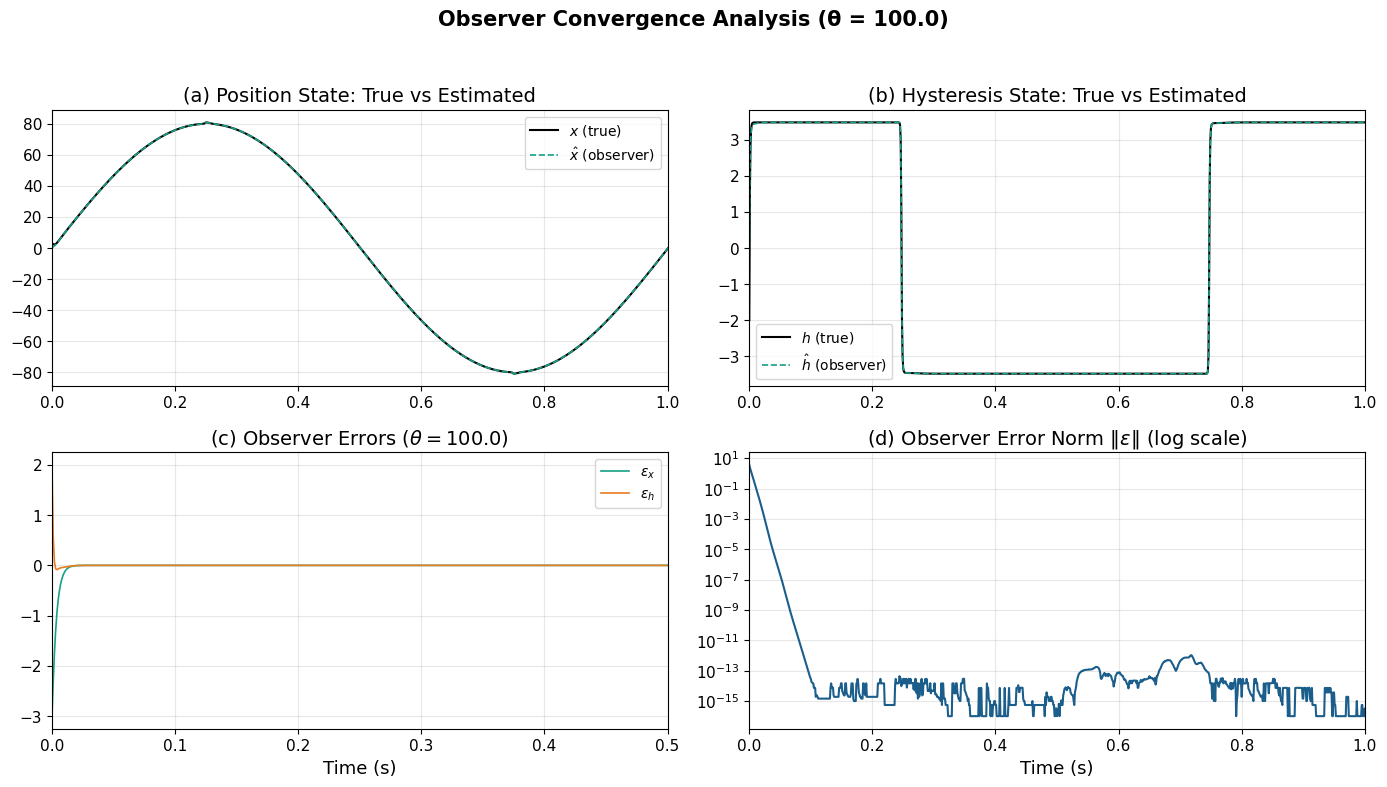

In [102]:
print("\n📐 Observer Convergence Analysis:")
plot_observer_detail(sol_robust, obs_gain_default)


📊 Testing across all parameter sets (Fig. 8 from paper):
  Simulating Set 1 (Baseline)...
  Simulating Set 2 (Wider loop)...
  Simulating Set 3 (Asymmetric)...
  Simulating Set 4 (Strong hyst.)...


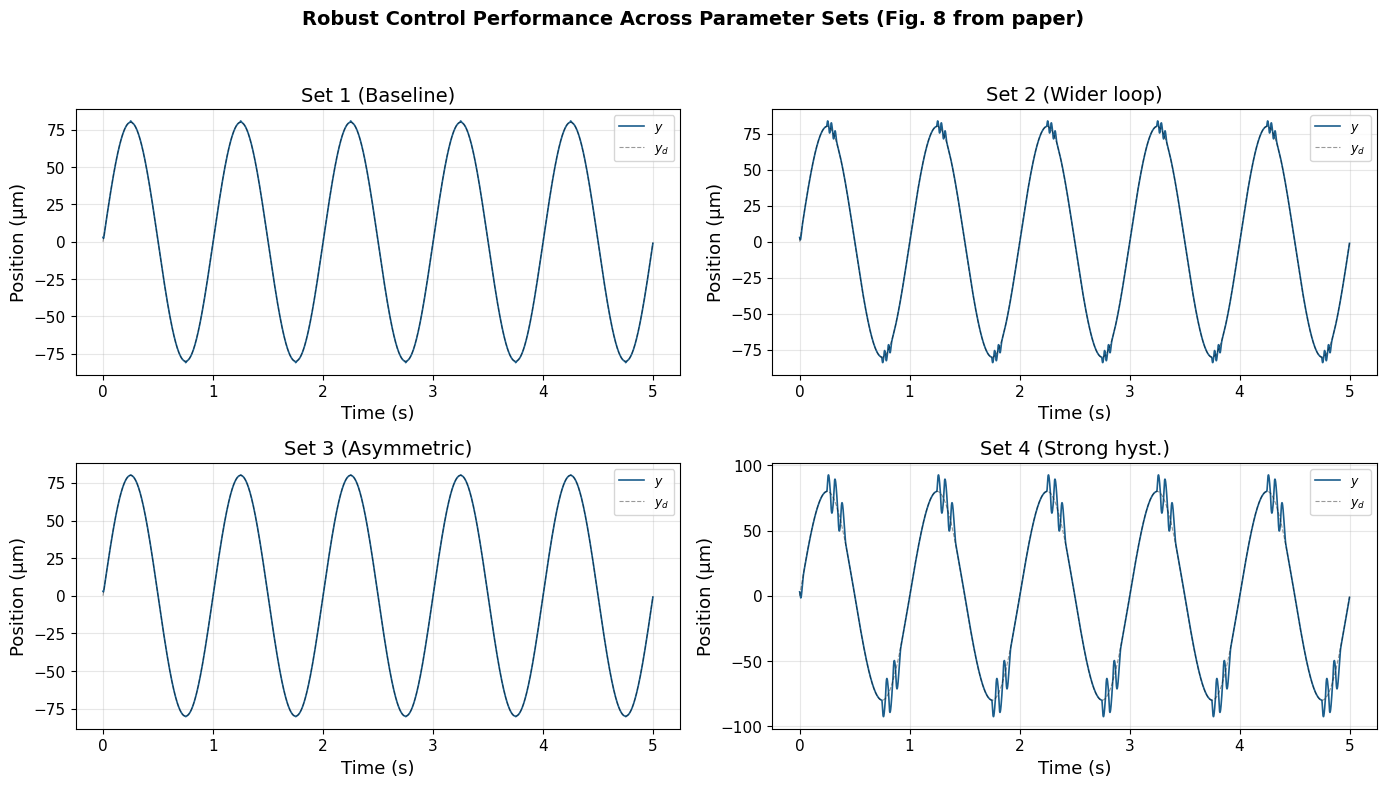

In [107]:
print("\n📊 Testing across all parameter sets (Fig. 8 from paper):")
plot_hysteresis_sets(PARAM_SETS, ctrl_gains_default, obs_gain_default,
                     [0, T_FINAL], DT)

## 🌊 Robustness Under External Disturbances

Testing with δ_x = 30 μm (constant) and δ_h = 25 sin(t) μm.


🌊 Simulation with disturbances (δ_x=30, δ_h=25sin(t)):
  Robust control...
  PID control...
  Open-loop...


/var/folders/vr/87wp5c1x6274y4s_9gfd2r8xg10zkr/T/ipykernel_30037/1461810231.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


  Saved: fig_comparison_disturbance.png


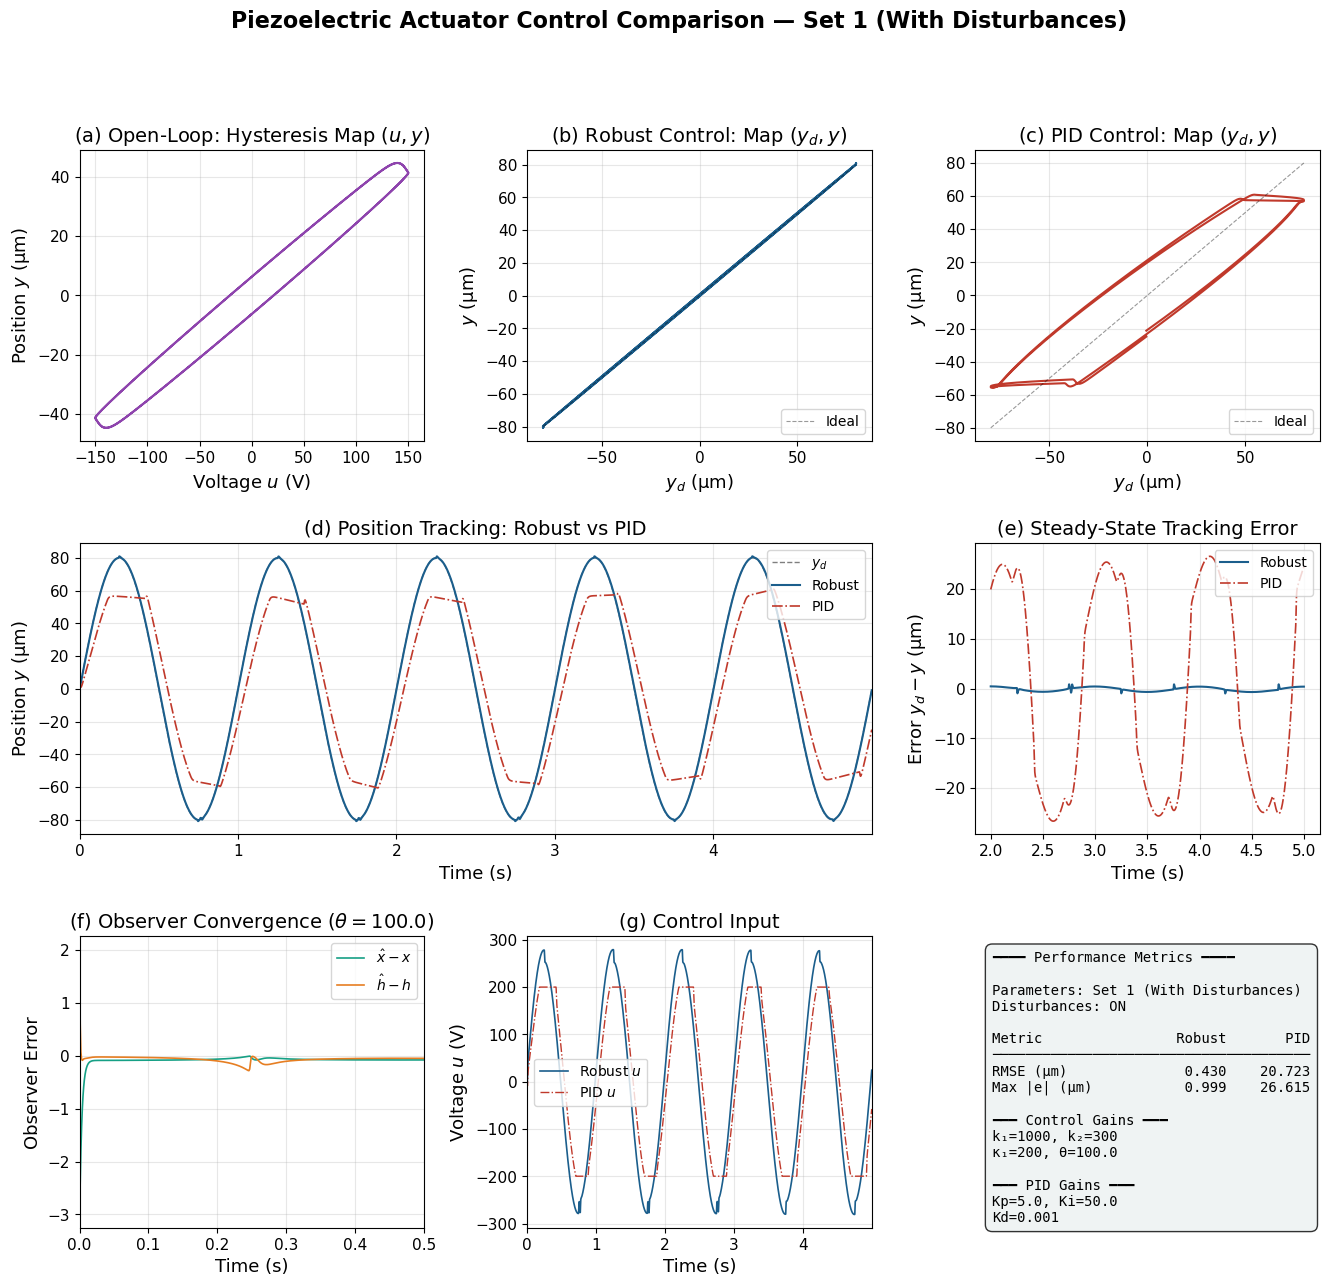

In [104]:
print("\n🌊 Simulation with disturbances (δ_x=30, δ_h=25sin(t)):")
print("  Robust control...")
sol_robust_d = simulate_robust_control(params, ctrl_gains_default, obs_gain_default,
                                        [0, T_FINAL], DT, disturbance=True)
print("  PID control...")
sol_pid_d = simulate_pid(params, pid_gains_default, [0, T_FINAL], DT, disturbance=True)
print("  Open-loop...")
sol_ol_d = simulate_open_loop(params, [0, T_FINAL], DT)

plot_comparison(sol_robust_d, sol_pid_d, sol_ol_d,
                "Set 1 (With Disturbances)", ctrl_gains_default,
                pid_gains_default, obs_gain_default,
                disturbance=True,
                save_name="fig_comparison_disturbance.png")

## 🎛️ Interactive Parameter Exploration

Use the sliders below to explore how different parameters affect performance.

In [105]:

if INTERACTIVE:
    print("🎛️ Interactive mode available! Use the sliders below.\n")

    # --- Layout ---
    style = {'description_width': '120px'}
    layout = widgets.Layout(width='400px')

    # Control gains
    w_k1 = widgets.FloatSlider(value=800, min=100, max=5000, step=100,
                                description='k₁ (tracking):', style=style, layout=layout)
    w_k2 = widgets.FloatSlider(value=500, min=10, max=2000, step=10,
                                description='k₂ (√ term):', style=style, layout=layout)
    w_kappa1 = widgets.FloatSlider(value=500, min=10, max=2000, step=10,
                                    description='κ₁ (virtual):', style=style, layout=layout)
    w_theta = widgets.FloatSlider(value=100, min=10, max=500, step=10,
                                   description='θ (observer):', style=style, layout=layout)

    # PID gains
    w_kp = widgets.FloatSlider(value=5.0, min=0.1, max=20, step=0.1,
                                description='Kp:', style=style, layout=layout)
    w_ki = widgets.FloatSlider(value=50.0, min=0, max=200, step=5,
                                description='Ki:', style=style, layout=layout)
    w_kd = widgets.FloatSlider(value=0.001, min=0.0, max=0.01, step=0.0005,
                                description='Kd:', style=style, layout=layout,
                                readout_format='.4f')

    # System
    w_params = widgets.Dropdown(options=list(PARAM_SETS.keys()),
                                 value="Set 1 (Baseline)",
                                 description='Param Set:', style=style, layout=layout)
    w_dist = widgets.Checkbox(value=False, description='Enable disturbances',
                               style=style)
    w_tfinal = widgets.FloatSlider(value=5, min=2, max=20, step=1,
                                    description='T_final (s):', style=style, layout=layout)

    run_button = widgets.Button(description='▶ Run Simulation',
                                 button_style='success',
                                 layout=widgets.Layout(width='200px', height='40px'))
    output = widgets.Output()

    def on_run(b):
        with output:
            clear_output(wait=True)

            cg = {"k1": w_k1.value, "k2": w_k2.value, "kappa1": w_kappa1.value}
            pg = {"Kp": w_kp.value, "Ki": w_ki.value, "Kd": w_kd.value}
            theta = w_theta.value
            p = PARAM_SETS[w_params.value]
            tf = w_tfinal.value
            dist = w_dist.value

            print(f"🔄 Running simulation: {w_params.value}, T={tf}s, Dist={'ON' if dist else 'OFF'}")

            try:
                sol_ol_i = simulate_open_loop(p, [0, tf], DT)
                sol_r_i = simulate_robust_control(p, cg, theta, [0, tf], DT, disturbance=dist)
                sol_p_i = simulate_pid(p, pg, [0, tf], DT, disturbance=dist)

                plot_comparison(sol_r_i, sol_p_i, sol_ol_i,
                                w_params.value, cg, pg, theta, disturbance=dist)
                plot_observer_detail(sol_r_i, theta)
            except Exception as ex:
                print(f"❌ Error: {ex}")
                import traceback
                traceback.print_exc()

    run_button.on_click(on_run)

    # Layout the widgets
    robust_box = widgets.VBox([
        widgets.HTML('<h4>🔧 Robust Nonlinear Control</h4>'),
        w_k1, w_k2, w_kappa1, w_theta
    ])
    pid_box = widgets.VBox([
        widgets.HTML('<h4>📏 PID Control</h4>'),
        w_kp, w_ki, w_kd
    ])
    system_box = widgets.VBox([
        widgets.HTML('<h4>⚙️ System Settings</h4>'),
        w_params, w_dist, w_tfinal
    ])

    controls = widgets.HBox([robust_box, pid_box, system_box])
    display(widgets.VBox([controls, run_button, output]))

else:
    print("\n💡 To use interactive sliders, run this notebook in Google Colab!")
    print("   Just modify the parameters in the cells above and re-run.")

🎛️ Interactive mode available! Use the sliders below.



## 🔍 Study: Effect of Observer Gain θ

The observer gain θ controls convergence speed.
Larger θ → faster convergence but potential peaking.


🔍 Effect of observer gain θ on convergence:
  θ = 20...
  θ = 100...
  θ = 300...


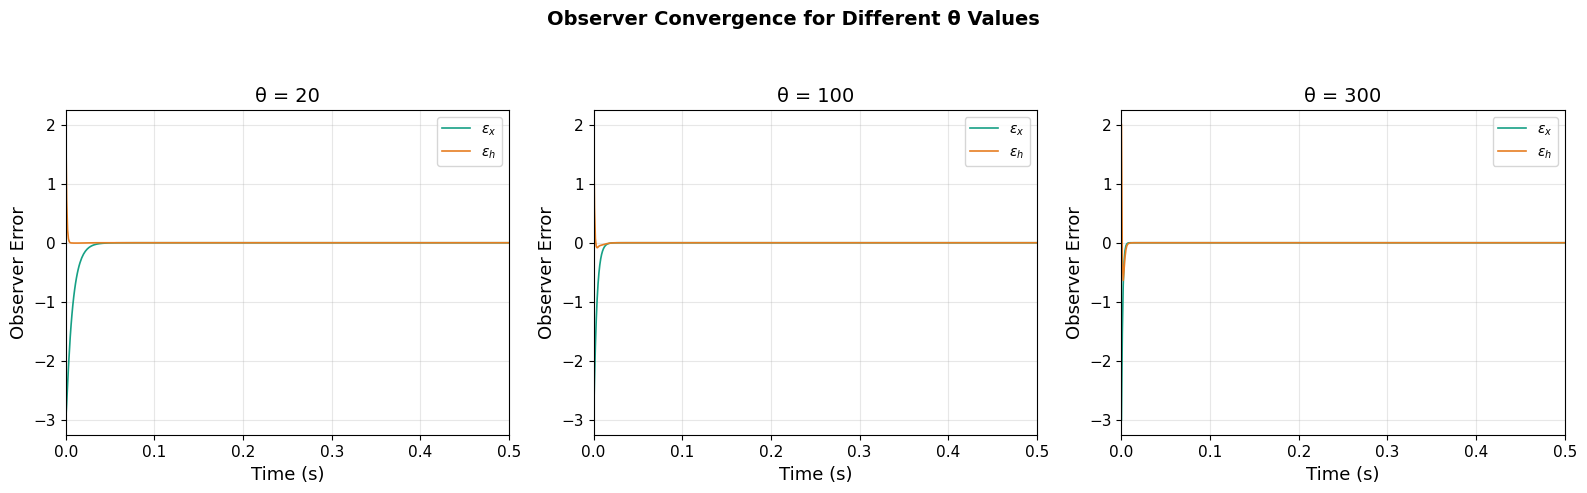

In [106]:
print("\n🔍 Effect of observer gain θ on convergence:")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
theta_values = [20, 100, 300]

for idx, theta_val in enumerate(theta_values):
    print(f"  θ = {theta_val}...")
    sol = simulate_robust_control(params, ctrl_gains_default, theta_val,
                                   [0, 2], DT)
    t = sol.t
    eps_x = sol.y[3] - sol.y[0]
    eps_h = sol.y[4] - sol.y[1]

    axes[idx].plot(t, eps_x, color=COLORS['observer'], lw=1.2, label='$\\epsilon_x$')
    axes[idx].plot(t, eps_h, color=COLORS['dist'], lw=1.2, label='$\\epsilon_h$')
    axes[idx].set_title(f'θ = {theta_val}')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Observer Error')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 0.5])

fig.suptitle('Observer Convergence for Different θ Values', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

## 📋 Summary

### Key Takeaways:

1. **Robust Nonlinear Control** achieves near-perfect hysteresis compensation because
   it explicitly models the Bouc-Wen dynamics and uses an observer to reconstruct
   the hysteresis state.

2. **PID Control** can reduce tracking error but cannot fully compensate
   for the nonlinear hysteresis, especially at higher amplitudes.

3. The **observer gain θ** trades off convergence speed against peaking;
   typical values of θ = 50–200 work well.

4. The robust approach maintains performance under **external disturbances**
   where PID degrades significantly.

5. The output-feedback scheme works with **position measurements only** —
   no hysteresis sensor needed.

### Exercises for Students:

1. Try increasing `Abw` to 1.5 — what happens to PID performance?
2. Set `k₁ = 0` — how does the controller behave without the √|e| term?
3. Enable disturbances and compare the steady-state errors.
4. Try `θ = 10` vs `θ = 500` — observe the peaking phenomenon.
5. Can you tune the PID gains to match the robust controller's performance?

In [42]:

print("="*65)
print("  ✅ Notebook complete!")
print("  All figures generated successfully.")
print("="*65)

  ✅ Notebook complete!
  All figures generated successfully.
